In [734]:
import torch

def h_poly_helper(tt):
  A = torch.tensor([
      [1, 0, -3, 2],
      [0, 1, -2, 1],
      [0, 0, 3, -2],
      [0, 0, -1, 1]
      ], dtype=tt[-1].dtype)
  return [
    sum( A[i, j]*tt[j] for j in range(4) )
    for i in range(4) ]

def h_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = 1
  for i in range(1, 4):
    tt[i] = tt[i-1]*t
  return h_poly_helper(tt)

def interp_func(x, y):
  "Returns integral of interpolating function"
  if len(y)>1:
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  def f(xs):
    if len(y)==1: # in the case of 1 point, treat as constant function
      return y[0] + torch.zeros_like(xs)
    I = torch.searchsorted(x[1:], xs)
    dx = (x[I+1]-x[I])
    hh = h_poly((xs-x[I])/dx)
    return hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
  return f

def interp(x, y, xs):
  return interp_func(x,y)(xs)

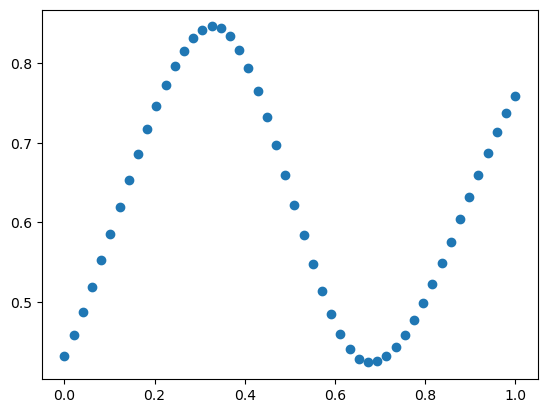

In [735]:
import matplotlib.pyplot as plt # for plotting
x = torch.rand(4)
u = torch.linspace(0, 1, 4)
us = torch.linspace(0, 1, 50)
xs = interp(u, x, us)
plt.plot(us, xs, 'o')

In [736]:
def cubic_spline(u, x, us):
    a = x[:-1]
    du = u[1:] - u[:-1]
    dx = x[1:] - x[:-1]
    diff = dx / du
    
    m0 = torch.tensor([0])
    m1 = 6*(x[2] - x[1])/(u[2] - u[1]) - 6*((x[1] - x[0])/(u[1] - u[0])) / 2 / (du[0] + du[1])
    m2 = 6*(x[3] - x[2])/(u[3] - u[2]) - 6*((x[2] - x[1])/(u[2] - u[1])) / 2 / (du[2] + du[1])
    m3 = torch.tensor([0])
    m = torch.hstack([m0, m1, m2, m3])

    c = m / 2

    b0 = diff[0] - du[0] * m[0] / 2 - du[0] * (m[1] - m[0]) / 6
    b1 = diff[1] - du[1] * m[1] / 2 - du[1] * (m[2] - m[1]) / 6
    b2 = diff[2] - du[2] * m[2] / 2 - du[2] * (m[3] - m[2]) / 6

    d0 = (m[1] - m[0]) / 6 / du[0]
    d1 = (m[2] - m[1]) / 6 / du[1]
    d2 = (m[3] - m[2]) / 6 / du[2]

    b = torch.hstack([b0, b1, b2])
    d = torch.hstack([d0, d1, d2])

    I = torch.searchsorted(u[1:], us)
    du = us - u[I]
    array = a[I] + b[I]*du + c[I]*du**2 + d[I]*du**3

    return array

In [737]:
ys = cubic_spline(u, x, us)

In [738]:
from scipy.interpolate import interp1d
f = interp1d(u, x, axis=0, kind='cubic')
zs = f(us)

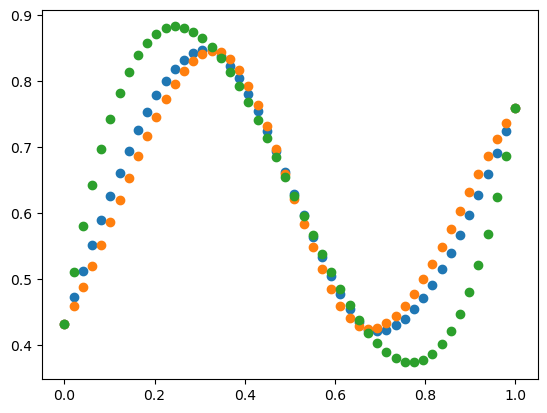

In [739]:
plt.plot(us, ys, 'o')
plt.plot(us, xs, 'o')
plt.plot(us, zs, 'o')

In [740]:
x_con = torch.rand(4).requires_grad_(True)

In [741]:
x_con

tensor([0.9579, 0.8266, 0.1674, 0.7395], requires_grad=True)

In [742]:
x_pre0 = cubic_spline(u, x_con, us)
# x_pre0 = cubic_interp(coff, u, us)

In [743]:
optimizer = torch.optim.SGD([x_con], lr=0.01)

In [744]:
def loss_fn(target, predict):
    return torch.norm(target - predict)

In [745]:
def loss_coff(coff1, coff2):
    a1, b1, c1, d1 = coff1
    a2, b2, c2, d2 = coff2
    return torch.norm(a1 - a2) + torch.norm(b1 - b2) + torch.norm(c1 - c2) + torch.norm(d1 - d2)

In [746]:
loss_array = []
pre_loss = 100
for i in range(1000):
    x_pre = cubic_spline(u, x_con, us)
    # x_pre = cubic_interp(coff, u, us)

    loss = loss_fn(x_pre, xs)
    loss.backward()
    print(x_con.grad)
    optimizer.step()
    optimizer.zero_grad()
    if abs(loss.detach() - pre_loss) < 0.0001:
        loss_array.append(loss.detach())
        break
    pre_loss = loss.detach()
    loss_array.append(pre_loss)

tensor([ 1.7958,  0.4253, -2.7343, -0.4110])
tensor([ 1.8353,  0.4179, -2.6497, -0.3905])
tensor([ 1.8756,  0.4077, -2.5557, -0.3681])
tensor([ 1.9164,  0.3942, -2.4512, -0.3436])
tensor([ 1.9569,  0.3769, -2.3354, -0.3171])
tensor([ 1.9965,  0.3553, -2.2075, -0.2885])
tensor([ 2.0342,  0.3289, -2.0671, -0.2579])
tensor([ 2.0690,  0.2973, -1.9142, -0.2255])
tensor([ 2.0995,  0.2602, -1.7495, -0.1917])
tensor([ 2.1246,  0.2177, -1.5745, -0.1572])
tensor([ 2.1431,  0.1699, -1.3915, -0.1226])
tensor([ 2.1543,  0.1175, -1.2038, -0.0890])
tensor([ 2.1576,  0.0615, -1.0154, -0.0576])
tensor([ 2.1530,  0.0030, -0.8307, -0.0293])
tensor([ 2.1412, -0.0564, -0.6538, -0.0053])
tensor([ 2.1229, -0.1152, -0.4887,  0.0133])
tensor([ 2.0992, -0.1719, -0.3384,  0.0258])
tensor([ 2.0710, -0.2252, -0.2050,  0.0315])
tensor([ 2.0389, -0.2738, -0.0897,  0.0299])
tensor([ 2.0030, -0.3166,  0.0073,  0.0205])
tensor([ 1.9626, -0.3526,  0.0861,  0.0031])
tensor([ 1.9154, -0.3807,  0.1477, -0.0226])
tensor([ 1

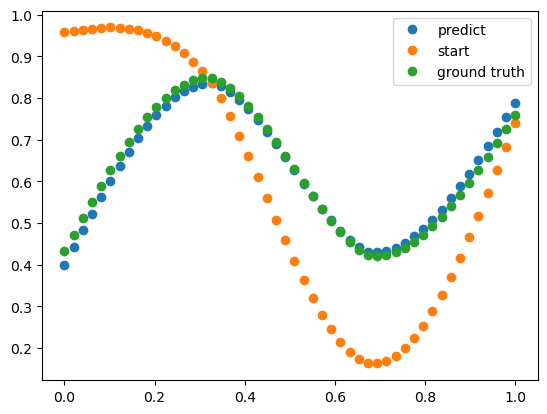

In [747]:
plt.plot(us, x_pre.detach(), 'o', label='predict')
plt.plot(us, x_pre0.detach(), 'o', label='start')
plt.plot(us, ys.detach(), 'o', label = 'ground truth')
plt.legend()

In [748]:
x_con

tensor([0.3996, 0.8349, 0.4323, 0.7892], requires_grad=True)

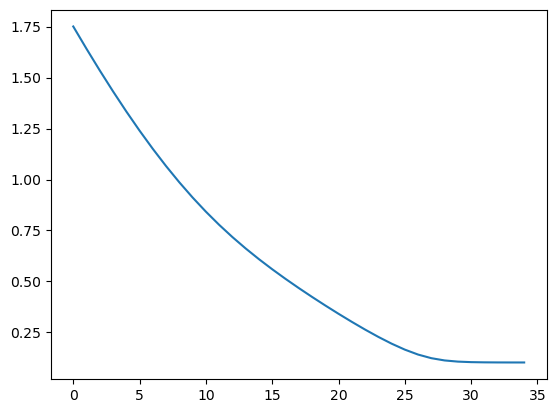

In [749]:
plt.plot(loss_array)

In [750]:
x_pre

tensor([0.4000, 0.4415, 0.4825, 0.5230, 0.5624, 0.6005, 0.6369, 0.6713, 0.7033,
        0.7327, 0.7591, 0.7821, 0.8015, 0.8169, 0.8279, 0.8342, 0.8355, 0.8280,
        0.8138, 0.7951, 0.7727, 0.7472, 0.7191, 0.6892, 0.6581, 0.6265, 0.5948,
        0.5639, 0.5343, 0.5066, 0.4816, 0.4598, 0.4419, 0.4310, 0.4299, 0.4334,
        0.4411, 0.4528, 0.4680, 0.4866, 0.5083, 0.5326, 0.5593, 0.5882, 0.6189,
        0.6511, 0.6845, 0.7188, 0.7537, 0.7889], grad_fn=<AddBackward0>)

In [751]:
x_pre0

tensor([0.9579, 0.9613, 0.9644, 0.9670, 0.9688, 0.9696, 0.9691, 0.9670, 0.9632,
        0.9573, 0.9490, 0.9382, 0.9246, 0.9079, 0.8878, 0.8642, 0.8366, 0.7995,
        0.7559, 0.7093, 0.6606, 0.6103, 0.5594, 0.5084, 0.4583, 0.4097, 0.3633,
        0.3200, 0.2804, 0.2453, 0.2155, 0.1917, 0.1746, 0.1650, 0.1629, 0.1683,
        0.1804, 0.1989, 0.2233, 0.2531, 0.2878, 0.3269, 0.3699, 0.4163, 0.4657,
        0.5175, 0.5713, 0.6265, 0.6827, 0.7395], grad_fn=<AddBackward0>)